In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

%run utility_functions.py # functions reused throughout

-1    4849
 1    1001
Name: cleave, dtype: int64

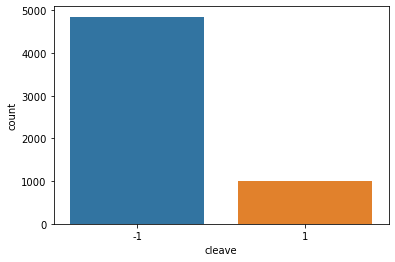

In [2]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates

# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')

sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)
# skewed toward predicting negative because more examples?

In [3]:
# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage
y = data['cleave']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)


In [4]:
# default 'adam' and relu
clf = MLPClassifier(random_state=0, early_stopping=True)

parameters = {'hidden_layer_sizes': np.arange(1, 6),
              'alpha': 10.0 ** -np.arange(1, 10),
              'max_iter': 100 * np.arange(3, 7),
              'n_iter_no_change': [10, 20, 30, 40],
              'learning_rate': ['constant', 'adaptive', 'invscaling']
             }


# scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_

In [5]:
# train model
clf.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=40, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.603


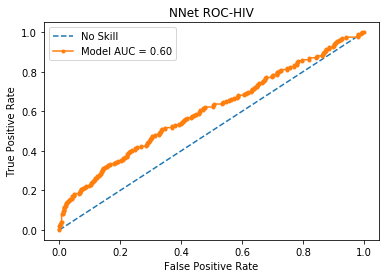

Model: f1=0.126 auc=0.301


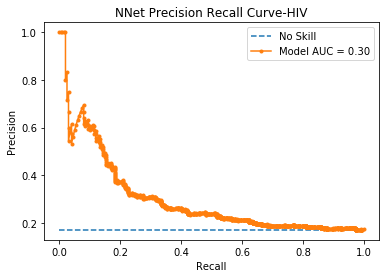

Classification Report
              precision    recall  f1-score   support

          -1       0.84      0.99      0.91       969
           1       0.67      0.07      0.13       201

    accuracy                           0.83      1170
   macro avg       0.75      0.53      0.52      1170
weighted avg       0.81      0.83      0.77      1170

Confusion Matrix
[[962   7]
 [187  14]]
Accuracy
0.8341880341880342
Balanced Accuracy
0.531213899542535


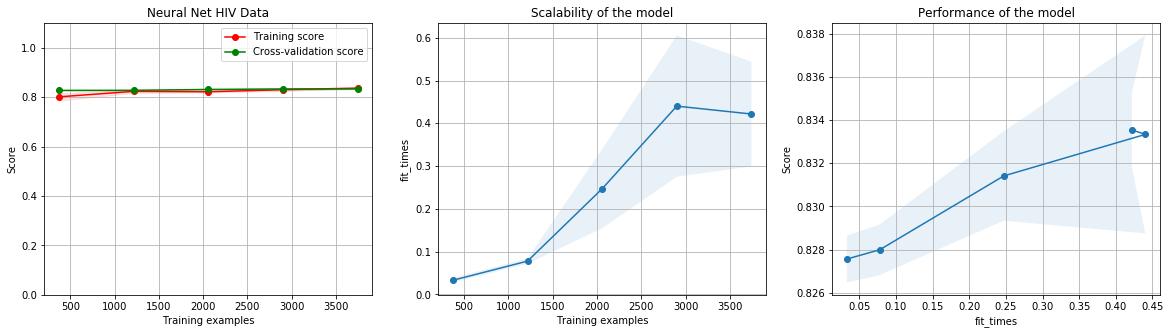

In [6]:
# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'NNet ROC-HIV')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'NNet Precision Recall Curve-HIV')

# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))
print('Accuracy')
print(accuracy_score(y_test, y_predict))

# for unbalanced data
print('Balanced Accuracy')
print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "Neural Net HIV Data", x_train, y_train, ylim=[0,1.1])

# filter warnings

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

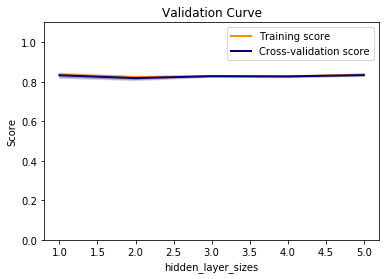

In [7]:
plot_model_complexity_analysis(clf, 'hidden_layer_sizes', np.arange(1, 6), 'NN_HIV', x_train, y_train)

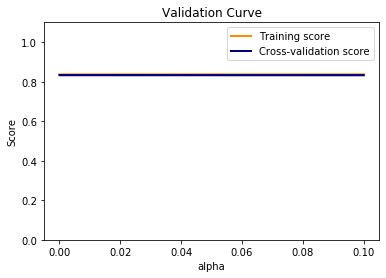

In [8]:
plot_model_complexity_analysis(clf, 'alpha', 10.0 ** -np.arange(1, 10), 'NN_HIV', x_train, y_train)

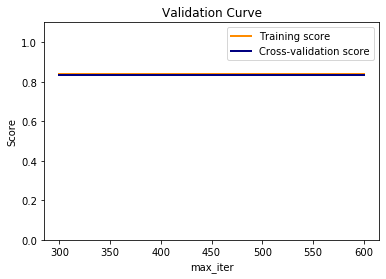

In [9]:
plot_model_complexity_analysis(clf, 'max_iter', 100 * np.arange(3, 7), 'NN_HIV', x_train, y_train)

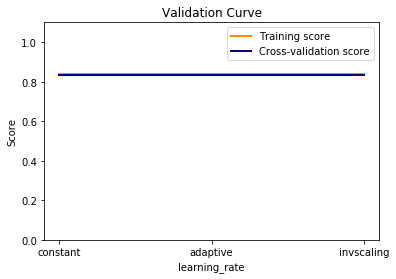

In [10]:
plot_model_complexity_analysis(clf, 'learning_rate', ['constant', 'adaptive', 'invscaling'], 'NN_HIV', x_train, y_train)

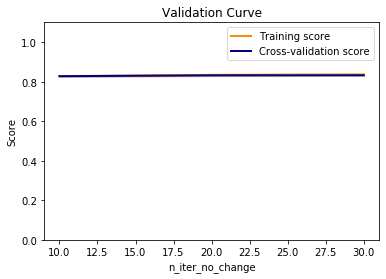

In [11]:
plot_model_complexity_analysis(clf, 'n_iter_no_change', [10, 20, 30], 'NN_HIV', x_train, y_train)